In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import lightgbm as lgb

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 4

In [3]:
import sys
sys.path.insert(0, 'C:\\Users\\albri\\Jupiter Workspace')
import albridge_lib as alb

## Продажи

In [4]:
sales = pd.read_csv('sales_history.csv', index_col='Unnamed: 0', parse_dates=['sale_dt'])
sales.info()

C:\Users\albri\.conda\envs\python38\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15259994 entries, 0 to 20083905
Data columns (total 5 columns):
 #   Column          Dtype         
---  ------          -----         
 0   salerevenuerub  float64       
 1   soldpieces      int64         
 2   skutertiaryid   int64         
 3   posid           int64         
 4   sale_dt         datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 698.5 MB


In [5]:
sales

,salerevenuerub,soldpieces,skutertiaryid,posid,sale_dt
0,174.416390,2,7182,293136,2018-04-30
1,261.641400,3,7182,293136,2018-04-23
2,78.750250,1,7182,296672,2018-04-30
3,630.035630,8,7182,296672,2018-04-23
4,239.120510,3,7182,296833,2018-04-30
...,...,...,...,...,...
20083899,1396.308385,21,7182,320402,2020-12-28
20083900,729.517920,10,7182,320402,2020-12-21
20083903,197.584800,2,7182,320402,2020-12-01
20083904,395.169600,4,7182,320402,2020-12-07


In [6]:
sales['week'] = sales['sale_dt'].dt.week
sales['year'] = sales['sale_dt'].dt.year
sales.head()

<ipython-input-6-41794714c090>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  sales['week'] = sales['sale_dt'].dt.week


,salerevenuerub,soldpieces,skutertiaryid,posid,sale_dt,week,year
0,174.41639,2,7182,293136,2018-04-30,18,2018
1,261.64140,3,7182,293136,2018-04-23,17,2018
2,78.75025,1,7182,296672,2018-04-30,18,2018
3,630.03563,8,7182,296672,2018-04-23,17,2018
4,239.12051,3,7182,296833,2018-04-30,18,2018


Дубликаты

In [7]:
sales.duplicated().sum()

9893

In [8]:
sales.drop_duplicates(inplace=True)
sales.shape

(15250101, 7)

Суммарные продажи

<AxesSubplot:xlabel='sale_dt'>

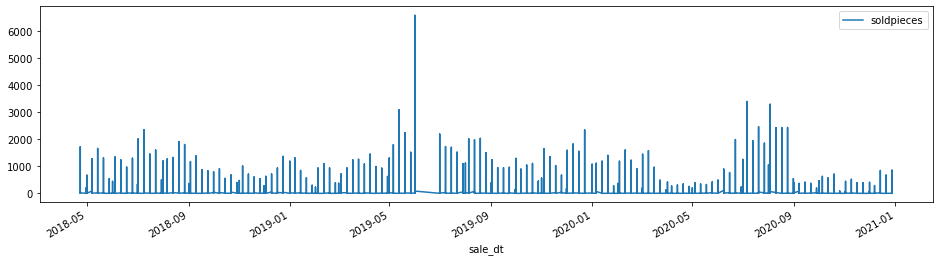

In [9]:
sales.plot(x='sale_dt', y='soldpieces')

Распределения

In [10]:
sales['skutertiaryid'].value_counts()

7234    1962128
7205    1952460
7194    1877059
7193    1719999
7182    1493553
7189    1343866
7232    1313962
7236    1234268
7247    1218748
7238    1134058
Name: skutertiaryid, dtype: int64

In [11]:
sales['posid'].value_counts()

272892    1554
300231    1521
296149    1520
279221    1518
276248    1514
          ... 
302599      59
303698      44
319568      40
304998      33
304206      26
Name: posid, Length: 14518, dtype: int64

<AxesSubplot:>

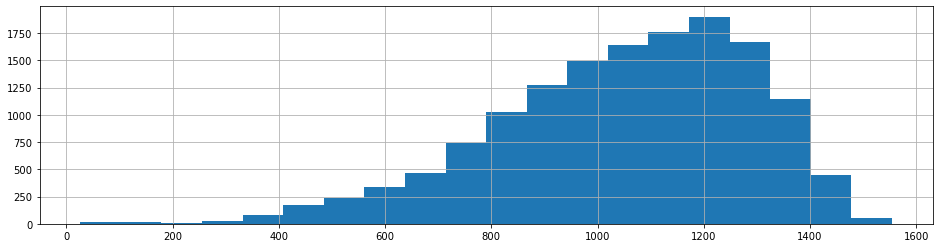

In [12]:
sales['posid'].value_counts().hist(bins=20)

#### Таблица магазинов

In [14]:
shop_table = sales.pivot_table(index='posid', 
                               values='soldpieces', 
                               aggfunc='sum').sort_values('soldpieces', ascending=False)
shop_table

,soldpieces
posid,
295970,275972
300233,240343
277870,225126
300234,183139
271015,175831
...,...
304998,402
300545,262
319568,254


array([[<AxesSubplot:title={'center':'soldpieces'}>]], dtype=object)

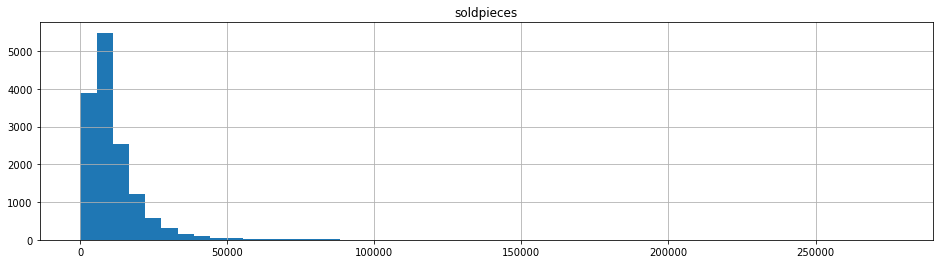

In [16]:
shop_table.hist(bins=50)

<AxesSubplot:>

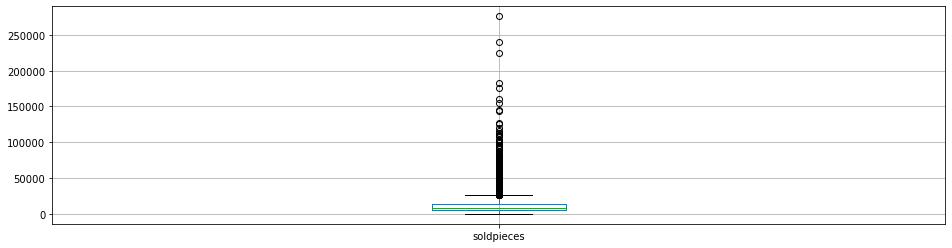

In [17]:
shop_table.boxplot()

#### Цены товаров

In [18]:
sales['prices'] = sales['salerevenuerub'] / sales['soldpieces']
price_table = sales.pivot_table(index='sale_dt', values='prices', columns='skutertiaryid', aggfunc='mean')
price_table

skutertiaryid,7182,7189,7193,7194,7205,7232,7234,7236,7238,7247
sale_dt,,,,,,,,,,
2018-04-23,83.651286,20.765593,29.412636,67.055305,17.186841,56.886128,68.448634,4.279837,NaN,6.720065
2018-04-30,83.596190,20.501582,29.461719,66.256942,17.095958,56.775920,67.163130,4.600648,NaN,6.718831
2018-05-01,83.717242,19.263435,29.448933,66.966924,17.260082,56.909067,62.003774,4.458424,NaN,6.702131
2018-05-07,76.796632,19.826688,23.237814,51.403677,14.437377,45.637655,65.030439,4.632308,NaN,6.704131
2018-05-14,79.687162,20.330206,25.728409,57.764006,15.625136,50.263829,67.340350,4.769765,20.122461,6.722740
...,...,...,...,...,...,...,...,...,...,...
2020-12-01,98.934022,20.971965,39.868273,71.121386,17.464429,66.095552,69.655696,7.583428,38.071336,6.414814
2020-12-07,98.965978,20.971322,39.707531,71.160873,19.296307,68.619381,77.644843,7.589233,41.707386,7.151734
2020-12-14,99.157942,17.360154,39.797198,58.716031,20.622026,69.514390,82.440023,6.649834,40.385806,7.676283


<AxesSubplot:xlabel='sale_dt'>

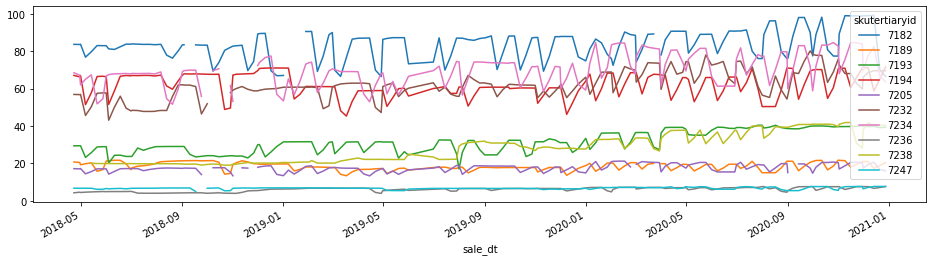

In [21]:
price_table.plot()

In [22]:
price_table.to_csv('prices.csv')

#### Продажи товаров по неделям

In [23]:
sku_sales = sales.pivot_table(index=['year','week'], values='soldpieces', columns='skutertiaryid', aggfunc='sum')
sku_sales

skutertiaryid      7182     7189      7193      7194      7205      7232  \
year week                                                                  
2018 17         48862.0  26343.0  118073.0  144725.0  133935.0   85292.0   
     18         55425.0  35697.0  150005.0  161841.0  179394.0  130049.0   
     19         63986.0  34392.0  203942.0  239710.0  241096.0  176543.0   
     20         57705.0  39083.0  178869.0  206299.0  214644.0  123243.0   
     21         47347.0  82345.0  132631.0  161391.0  172604.0   91567.0   
...                 ...      ...       ...       ...       ...       ...   
2020 49         36331.0  28869.0    2757.0   72688.0  150790.0   61573.0   
     50         37332.0  28028.0    2880.0   72336.0  117156.0   53248.0   
     51         40431.0  44200.0    2843.0  115336.0  117895.0   57930.0   
     52         97103.0  36691.0    2671.0   87113.0  215190.0   57407.0   
     53        136937.0  20271.0    1607.0   40953.0  254640.0   59293.0   

skutertiaryid      7234     7236      7238     7247  
year week                                            
2018 17        189190.0  13344.0       NaN    655.0  
     18        268688.0  16360.0       NaN    701.0  
     19        231905.0  14338.0       NaN    927.0  
     20        234963.0  16290.0   43255.0   1191.0  
     21        352574.0  15546.0  104729.0   1296.0  
...                 ...      ...       ...      ...  
2020 49        178530.0  30973.0   38530.0  61781.0  
     50        137213.0  31502.0   29053.0  44413.0  
     51        129978.0  44894.0   29140.0  36979.0  
     52        231798.0  36628.0   25462.0  36098.0  
     53        174547.0  18236.0   15299.0  28544.0  

[137 rows x 10 columns]

In [24]:
sku_sales.loc[2019,22] = sku_sales.loc[2019,22] / 5
for sku in sku_sales.columns:
    for week in [23,24,25,26]:
        sku_sales.loc[(2019,week), sku] = sku_sales.loc[(2019,22), sku]
sku_sales = sku_sales.sort_index()

<AxesSubplot:xlabel='year,week'>

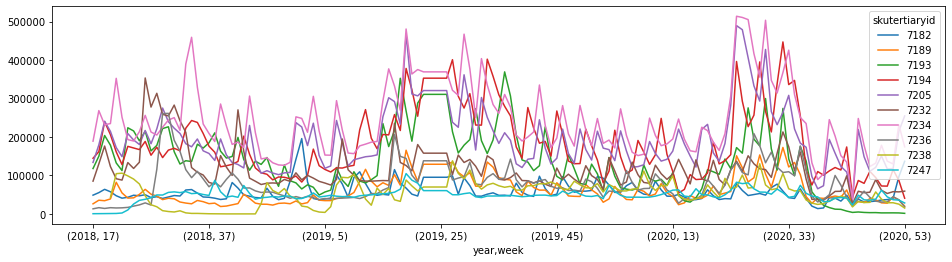

In [25]:
sku_sales.plot()

Ожидаемые продажи (усредненные)

In [27]:
mean_sales = sku_sales.pivot_table(index=['week'], aggfunc='mean').astype('int')
mean_sales.head()

skutertiaryid,7182,7189,7193,7194,7205,7232,7234,7236,7238,7247
week,,,,,,,,,,
1,144445,28264,61996,81865,198634,76428,215983,42399,38795,39904
2,79144,34262,111233,106036,172482,123372,202228,52760,47245,59854
3,48107,60464,83763,193093,187234,102302,238701,50351,38868,56687
4,46719,43708,58659,136974,183936,79924,244451,47106,32429,46229
5,56124,36177,60800,110567,141409,81684,178774,76680,31960,44901


<AxesSubplot:xlabel='week'>

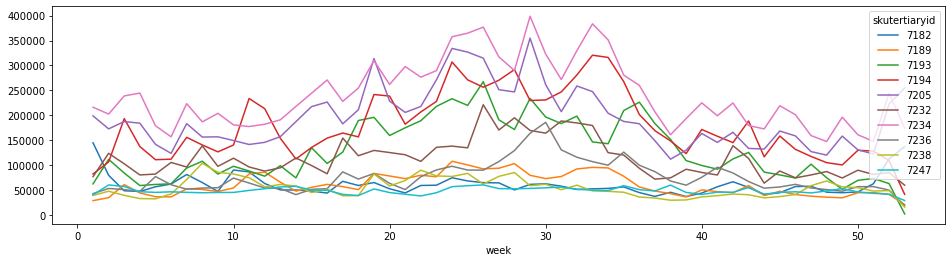

In [28]:
mean_sales.plot()

Сглаживаем, чтобы минимизировать выбросы и влияние промоакций

In [29]:
def cyclic_roll(mean_sales, wind):
    
    shift1 = int(wind/2)+1
    shift2 = wind+shift1
    res = pd.DataFrame()
    
    for col in mean_sales:
        aaa = mean_sales[col][-shift2:].append(mean_sales[col])
        rolling = aaa.shift().rolling(wind).mean()
        mean_sales_roll = rolling[wind:].shift(-shift1).append(rolling[:shift1])
        mean_sales_roll = mean_sales_roll.sort_index()
        mean_sales_roll.dropna(inplace=True)
        res[col] = mean_sales_roll
    return res

In [30]:
mean_sales_roll = cyclic_roll(mean_sales, 5)

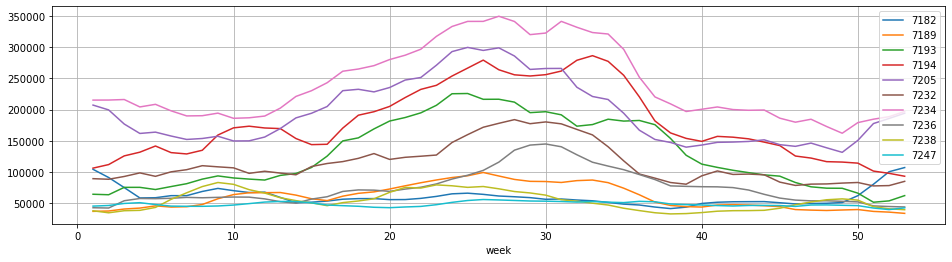

In [31]:
mean_sales_roll.plot()
plt.grid()

In [32]:
mean_sales_roll.to_csv('mean_sales_roll.csv')

## Промо

In [33]:
promos = pd.read_excel('promo_history.xlsx', index_col='Unnamed: 0')
promos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 0 to 160
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_dttm          103 non-null    datetime64[ns]
 1   end_dttm            103 non-null    datetime64[ns]
 2   skutertiaryid       103 non-null    int64         
 3   promotypeid         103 non-null    int64         
 4   chaindiscountvalue  103 non-null    float64       
 5   0                   103 non-null    int64         
dtypes: datetime64[ns](2), float64(1), int64(3)
memory usage: 5.6 KB


In [34]:
promos.duplicated().sum()

0

In [35]:
promos.drop([0], axis=1, inplace=True)
promos['year'] = promos['start_dttm'].dt.year
promos = promos[promos['year']==2019]

In [36]:
promos['duration'] = (promos['end_dttm'] - promos['start_dttm']) / np.timedelta64(1, 'D') + 1
print(promos['duration'].value_counts())
promos = promos[promos['duration']>1]

7.0     34
14.0    14
1.0      2
28.0     1
29.0     1
Name: duration, dtype: int64


Разбиваем по неделям

In [38]:
for i in promos.index:
    dur = promos.loc[i,'duration']
    if dur > 7:
        N = int((dur-7)/7)
        new = promos.loc[i]
        for j in range(N):
            new['start_dttm'] = new['start_dttm'] + pd.Timedelta(days=7)
            promos = promos.append(new)
promos.sort_values('start_dttm', inplace=True, ignore_index=True)
promos.head(20)

<ipython-input-38-2cd7ace9b2cd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['start_dttm'] = new['start_dttm'] + pd.Timedelta(days=7)
<ipython-input-38-2cd7ace9b2cd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['start_dttm'] = new['start_dttm'] + pd.Timedelta(days=7)
<ipython-input-38-2cd7ace9b2cd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['start_dttm'] = new['start_dttm'] + pd.Timedelta(days=7)
<ipython-inpu

<ipython-input-38-2cd7ace9b2cd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['start_dttm'] = new['start_dttm'] + pd.Timedelta(days=7)
<ipython-input-38-2cd7ace9b2cd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['start_dttm'] = new['start_dttm'] + pd.Timedelta(days=7)
<ipython-input-38-2cd7ace9b2cd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['start_dttm'] = new['start_dttm'] + pd.Timedelta(days=7)


,start_dttm,end_dttm,skutertiaryid,promotypeid,chaindiscountvalue,year,duration
0,2019-01-16,2019-01-29,7205,67,0.228495,2019,14.0
1,2019-01-16,2019-01-29,7234,67,0.239229,2019,14.0
2,2019-01-23,2019-01-29,7234,67,0.239229,2019,14.0
3,2019-01-23,2019-01-29,7205,67,0.228495,2019,14.0
4,2019-01-23,2019-01-29,7205,67,0.228495,2019,14.0
5,2019-01-23,2019-01-29,7234,67,0.239229,2019,14.0
6,2019-01-30,2019-01-29,7205,67,0.228495,2019,14.0
7,2019-01-30,2019-01-29,7234,67,0.239229,2019,14.0
8,2019-02-13,2019-02-26,7182,70,0.233531,2019,14.0
9,2019-02-13,2019-02-26,7205,67,0.221040,2019,14.0


In [39]:
print(promos['duration'].value_counts())

14.0    56
7.0     34
28.0    16
29.0    16
Name: duration, dtype: int64


In [40]:
promos['week'] = promos['start_dttm'].dt.week
promos.head()

<ipython-input-40-3d15e62fdb4e>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  promos['week'] = promos['start_dttm'].dt.week


,start_dttm,end_dttm,skutertiaryid,promotypeid,chaindiscountvalue,year,duration,week
0,2019-01-16,2019-01-29,7205,67,0.228495,2019,14.0,3
1,2019-01-16,2019-01-29,7234,67,0.239229,2019,14.0,3
2,2019-01-23,2019-01-29,7234,67,0.239229,2019,14.0,4
3,2019-01-23,2019-01-29,7205,67,0.228495,2019,14.0,4
4,2019-01-23,2019-01-29,7205,67,0.228495,2019,14.0,4


In [41]:
promos['discount'] = (promos['chaindiscountvalue']*2).round(1)/2
promos['discount'].value_counts()

0.20    53
0.15    45
0.25    19
0.30     4
0.40     1
Name: discount, dtype: int64

In [42]:
promos['promo'] = promos['discount']!=0
promos

,start_dttm,end_dttm,skutertiaryid,promotypeid,chaindiscountvalue,year,duration,week,discount,promo
0,2019-01-16,2019-01-29,7205,67,0.228495,2019,14.0,3,0.25,True
1,2019-01-16,2019-01-29,7234,67,0.239229,2019,14.0,3,0.25,True
2,2019-01-23,2019-01-29,7234,67,0.239229,2019,14.0,4,0.25,True
3,2019-01-23,2019-01-29,7205,67,0.228495,2019,14.0,4,0.25,True
4,2019-01-23,2019-01-29,7205,67,0.228495,2019,14.0,4,0.25,True
...,...,...,...,...,...,...,...,...,...,...
117,2019-12-11,2019-12-17,7194,70,0.307070,2019,7.0,50,0.30,True
118,2019-12-25,2019-12-31,7234,70,0.248859,2019,7.0,52,0.25,True
119,2019-12-25,2019-12-31,7182,70,0.127571,2019,7.0,52,0.15,True
120,2019-12-25,2019-12-31,7205,70,0.247988,2019,7.0,52,0.25,True


In [43]:
promos['promotypeid'].value_counts()

70    90
67    16
77    16
Name: promotypeid, dtype: int64

In [44]:
promos['chaindiscountvalue'].describe()

count    122.000000
mean       0.191863
std        0.041473
min        0.127571
25%        0.159654
50%        0.175458
75%        0.216858
max        0.392280
Name: chaindiscountvalue, dtype: float64

In [45]:
promos[promos['skutertiaryid']==7234]

,start_dttm,end_dttm,skutertiaryid,promotypeid,chaindiscountvalue,year,duration,week,discount,promo
1,2019-01-16,2019-01-29,7234,67,0.239229,2019,14.0,3,0.25,True
2,2019-01-23,2019-01-29,7234,67,0.239229,2019,14.0,4,0.25,True
5,2019-01-23,2019-01-29,7234,67,0.239229,2019,14.0,4,0.25,True
7,2019-01-30,2019-01-29,7234,67,0.239229,2019,14.0,5,0.25,True
10,2019-02-13,2019-02-26,7234,67,0.216858,2019,14.0,7,0.20,True
14,2019-02-20,2019-02-26,7234,67,0.216858,2019,14.0,8,0.20,True
16,2019-02-20,2019-02-26,7234,67,0.216858,2019,14.0,8,0.20,True
18,2019-02-27,2019-02-26,7234,67,0.216858,2019,14.0,9,0.20,True
32,2019-04-10,2019-04-23,7234,70,0.142418,2019,14.0,15,0.15,True
35,2019-04-17,2019-04-23,7234,70,0.142418,2019,14.0,16,0.15,True


### Объединяем данные за 2019 год

Продажи за 2019 год

In [179]:
df_sales = sales[sales['year']==2019].pivot_table(index=['week','skutertiaryid'], values='soldpieces', aggfunc='sum')
df_sales.columns = ['sales']
df_sales.head()

sales
week skutertiaryid        
1    7182           195914
     7189            26086
     7193            65003
     7194            82928
     7205           226141

Поправляем июнь

In [180]:
for sku in mean_sales_roll.columns:
    df_sales.loc[(22, sku),'sales'] = df_sales.loc[(22, sku),'sales'] / 5
    for week in [23,24,25,26]:
        df_sales.loc[(week, sku),'sales'] = df_sales.loc[(22, sku),'sales']
df_sales = df_sales.sort_index()

In [181]:
df_sales.reset_index(inplace=True)
df_sales.head()

,week,skutertiaryid,sales
0,1,7182,195914.0
1,1,7189,26086.0
2,1,7193,65003.0
3,1,7194,82928.0
4,1,7205,226141.0


Промо

In [182]:
df_promos = promos.pivot_table(index='week',columns='skutertiaryid', values='chaindiscountvalue').notnull()
df_promos[7247] = pd.Series(data=[False]*len(df_promos))
df_promos.head()

skutertiaryid,7182,7189,7193,7194,7205,7232,7234,7236,7238,7247
week,,,,,,,,,,
3,False,False,False,False,True,False,True,False,False,False
4,False,False,False,False,True,False,True,False,False,False
5,False,False,False,False,True,False,True,False,False,False
7,True,False,False,False,True,False,True,False,False,False
8,True,False,False,False,True,False,True,False,False,False


In [183]:
df_promos.columns = ['promo_'+str(x) for x in df_promos.columns]
df_promos.reset_index(inplace=True)
df_promos.head()

,week,promo_7182,promo_7189,promo_7193,promo_7194,promo_7205,promo_7232,promo_7234,promo_7236,promo_7238,promo_7247
0,3,False,False,False,False,True,False,True,False,False,False
1,4,False,False,False,False,True,False,True,False,False,False
2,5,False,False,False,False,True,False,True,False,False,False
3,7,True,False,False,False,True,False,True,False,False,False
4,8,True,False,False,False,True,False,True,False,False,False


In [184]:
df = df_sales.merge(df_promos, how='left', left_on='week', right_on='week')
df.fillna(False, inplace=True)
#df.fillna(0, inplace=True)

In [185]:
for i in df.index:
    df.loc[i,'season'] = mean_sales_roll.loc[df.loc[i,'week'],df.loc[i,'skutertiaryid']]

In [186]:
df

,week,skutertiaryid,sales,promo_7182,promo_7189,promo_7193,promo_7194,promo_7205,promo_7232,promo_7234,promo_7236,promo_7238,promo_7247,season
0,1,7182,195914.0,False,False,False,False,False,False,False,False,False,False,104174.6
1,1,7189,26086.0,False,False,False,False,False,False,False,False,False,False,36816.6
2,1,7193,65003.0,False,False,False,False,False,False,False,False,False,False,64232.4
3,1,7194,82928.0,False,False,False,False,False,False,False,False,False,False,106105.6
4,1,7205,226141.0,False,False,False,False,False,False,False,False,False,False,207116.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,52,7232,89622.0,True,False,False,False,True,False,True,False,True,False,78130.4
516,52,7234,248066.0,True,False,False,False,True,False,True,False,True,False,188512.2
517,52,7236,66515.0,True,False,False,False,True,False,True,False,True,False,44584.8
518,52,7238,79058.0,True,False,False,False,True,False,True,False,True,False,40895.6


графики

In [187]:
def plot_by_good(df, goods):
    for sku in goods:
        data = df[df['skutertiaryid']==sku]
        fig, ax1 = plt.subplots(1,1)
        data.sales.plot(ax=ax1, marker='.', label='sales')
        data.season.plot(ax=ax1, marker='.', label='season', color='green')
        plt.legend()
        ax2 = ax1.twinx()
        #data['promo_'+str(sku)].plot(ax=ax2, secondary_y=True, marker='.', color='orange', label='promo')
        ax2.set_ylim([0,1])
        plt.legend()
        plt.title(sku)
        plt.grid()
        plt.show()

No handles with labels found to put in legend.


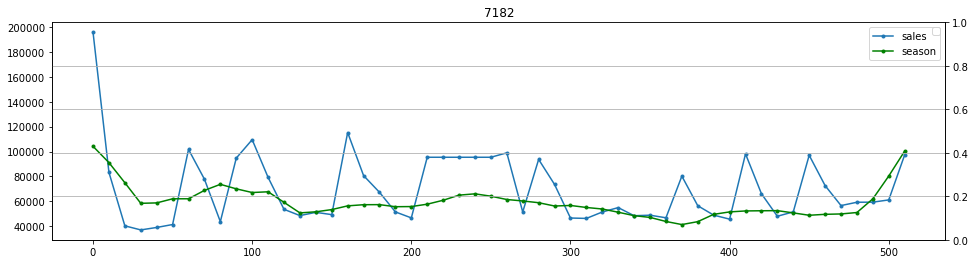

No handles with labels found to put in legend.


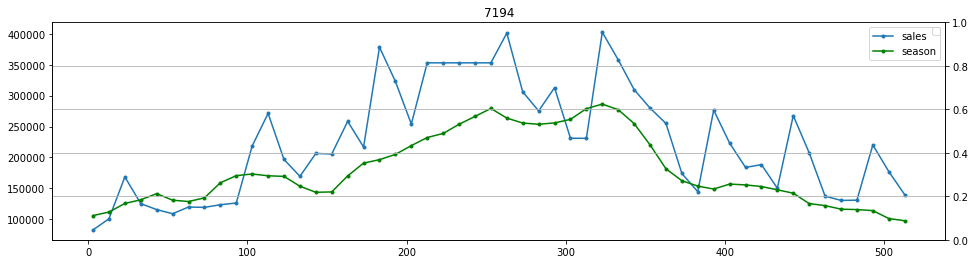

No handles with labels found to put in legend.


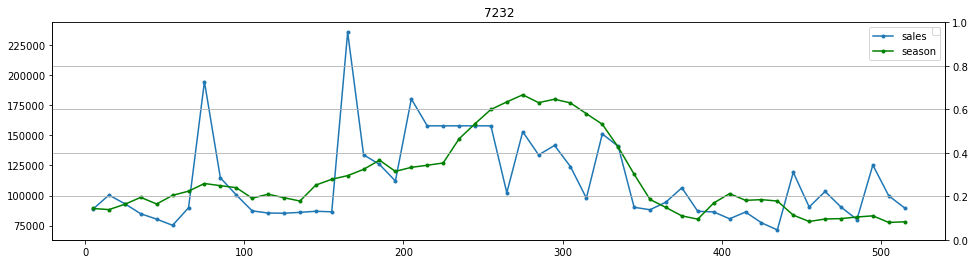

No handles with labels found to put in legend.


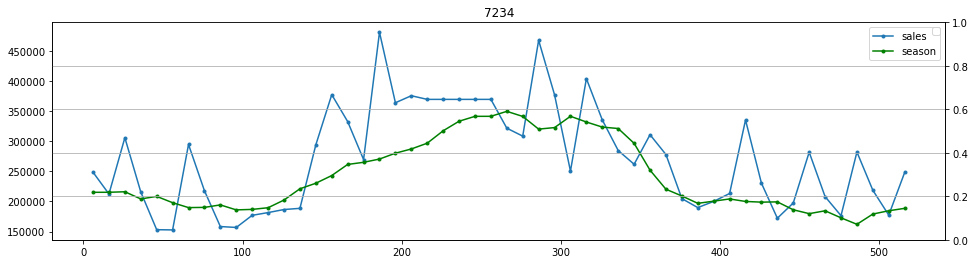

In [188]:
plot_by_good(df.reset_index(),[7182, 7194, 7232, 7234])

Выборки

In [189]:
cat_cols = ['skutertiaryid']
num_cols = ['season']
X = df.drop(['sales','week'], axis=1)
y = df['sales']
X.shape, y.shape

((520, 12), (520,))

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Обучающая выборка:', X_train.shape, y_train.shape)
print('Тестовая выборка: ', X_test.shape, y_test.shape)

Обучающая выборка: (416, 12) (416,)
Тестовая выборка:  (104, 12) (104,)


In [191]:
X_train_ohe = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
scaler = StandardScaler()
X_train_ohe[num_cols] = scaler.fit_transform(X_train_ohe[num_cols])
X_train_ohe.shape

(416, 20)

Dummy-решение только на основе усредненных данных о продажах, не учитывет промо-акции

In [192]:
print('rmse =', mean_squared_error(y, X['season'], squared=False))
print('mae =', mean_absolute_error(y, X['season']))

rmse = 47226.46180120356
mae = 31867.639615384614


Линейные модели

In [193]:
model = LinearRegression()
res = cross_val_score(model, X_train_ohe, y_train, scoring='neg_root_mean_squared_error', cv=10)
print('rmse =', -res.mean())
res = cross_val_score(model, X_train_ohe, y_train, scoring='neg_mean_absolute_error', cv=10)
print('mae =', -res.mean())

rmse = 39898.96549224864
mae = 30119.674418791827


In [194]:
model = Lasso()
res = cross_val_score(model, X_train_ohe, y_train, scoring='neg_root_mean_squared_error', cv=10)
print('rmse =', -res.mean())
res = cross_val_score(model, X_ohe, y, scoring='neg_mean_absolute_error', cv=10)
print('mae =', -res.mean())

rmse = 39867.781559949944
mae = 33602.76711424817


Fitting 10 folds for each of 8 candidates, totalling 80 fits


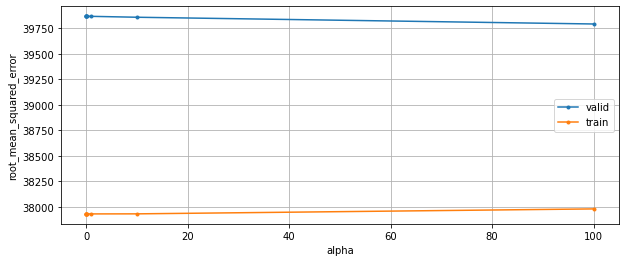

Best valid score: 39792.881 (3705.347)
Train score:      37980.326 (458.413)
Best params: {'alpha': 100}


,cv score,cv std,time,train score,train std
{'alpha': 1e-05},39868.748,3716.789,0.005,37931.226,462.713
{'alpha': 0.0001},39868.748,3716.788,0.006,37931.226,462.713
{'alpha': 0.001},39868.747,3716.788,0.005,37931.226,462.713
{'alpha': 0.01},39868.738,3716.785,0.005,37931.226,462.713
{'alpha': 0.1},39868.650,3716.753,0.005,37931.227,462.713
{'alpha': 1},39867.782,3716.432,0.004,37931.233,462.713
{'alpha': 10},39858.933,3713.716,0.004,37931.864,462.683
{'alpha': 100},39792.881,3705.347,0.004,37980.326,458.413


In [195]:
model = Lasso()
params = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100]}
alb.sklearn_gridCV(model, X_train_ohe, y_train, 'neg_root_mean_squared_error', params, cv=10, fit_train=True)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


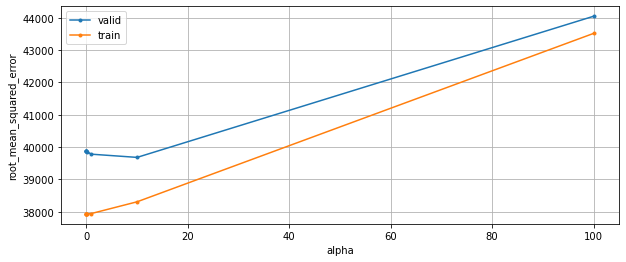

Best valid score: 39679.504 (4079.876)
Train score:      38305.963 (457.622)
Best params: {'alpha': 10}


,cv score,cv std,time,train score,train std
{'alpha': 1e-05},39868.747,3716.789,0.017,37931.226,462.713
{'alpha': 0.0001},39868.736,3716.789,0.004,37931.226,462.713
{'alpha': 0.001},39868.628,3716.793,0.004,37931.226,462.713
{'alpha': 0.01},39867.549,3716.833,0.003,37931.228,462.713
{'alpha': 0.1},39857.112,3717.439,0.003,37931.397,462.690
{'alpha': 1},39778.609,3737.389,0.004,37943.624,461.473
{'alpha': 10},39679.504,4079.876,0.004,38305.963,457.622
{'alpha': 100},44045.077,4332.469,0.004,43514.777,500.083


In [196]:
model = Ridge()
params = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100]}
alb.sklearn_gridCV(model, X_train_ohe, y_train, 'neg_root_mean_squared_error', params, cv=10, fit_train=True)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


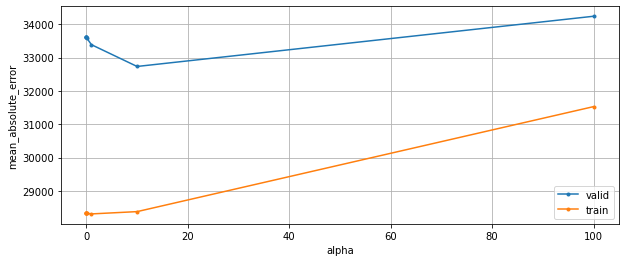

Best valid score: 32733.244 (8936.762)
Train score:      28382.524 (1015.733)
Best params: {'alpha': 10}


,cv score,cv std,time,train score,train std
{'alpha': 1e-05},33607.332,9393.559,0.004,28331.086,1083.928
{'alpha': 0.0001},33607.309,9393.545,0.005,28331.084,1083.927
{'alpha': 0.001},33607.076,9393.403,0.004,28331.064,1083.917
{'alpha': 0.01},33604.746,9391.986,0.004,28330.863,1083.815
{'alpha': 0.1},33581.810,9377.986,0.005,28328.956,1082.869
{'alpha': 1},33386.719,9250.576,0.004,28313.761,1074.448
{'alpha': 10},32733.244,8936.762,0.004,28382.524,1015.733
{'alpha': 100},34238.517,9763.190,0.005,31529.919,968.946


In [197]:
model = Ridge()
params = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100]}
alb.sklearn_gridCV(model, X_ohe, y, 'neg_mean_absolute_error', params, cv=10, fit_train=True)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


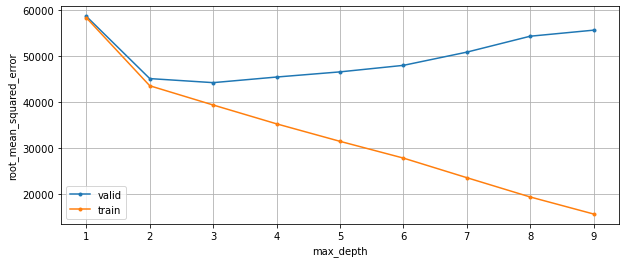

Best valid score: 44300.576 (8482.911)
Train score:      39442.503 (850.948)
Best params: {'max_depth': 3}


,cv score,cv std,time,train score,train std
{'max_depth': 1},58707.030,9335.943,0.004,58391.030,1017.740
{'max_depth': 2},45181.661,8282.764,0.004,43623.632,948.897
{'max_depth': 3},44300.576,8482.911,0.004,39442.503,850.948
{'max_depth': 4},45518.433,7919.266,0.003,35349.611,932.253
{'max_depth': 5},46640.105,7988.843,0.003,31550.042,796.855
{'max_depth': 6},48055.871,8437.278,0.004,27909.168,551.625
{'max_depth': 7},50928.632,8241.310,0.004,23654.449,914.110
{'max_depth': 8},54388.060,7378.386,0.004,19459.527,1030.525
{'max_depth': 9},55703.504,6073.596,0.004,15758.772,1422.267


In [78]:
model = DecisionTreeRegressor()
params = {'max_depth': range(1,10)}
alb.sklearn_gridCV(model, X_train_ohe, y_train, 'neg_root_mean_squared_error', params, cv=10, fit_train=True)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


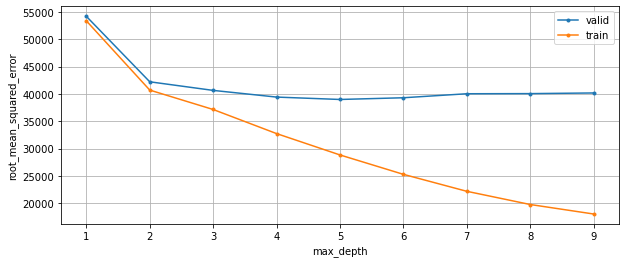

Best valid score: 38991.918 (7925.794)
Train score:      28823.970 (638.970)
Best params: {'max_depth': 5}


,cv score,cv std,time,train score,train std
{'max_depth': 1},54226.794,10074.222,0.130,53401.184,1209.055
{'max_depth': 2},42230.353,9088.877,0.129,40710.645,1019.789
{'max_depth': 3},40654.202,8686.854,0.138,37153.343,841.913
{'max_depth': 4},39429.401,8102.024,0.153,32737.958,688.302
{'max_depth': 5},38991.918,7925.794,0.144,28823.970,638.970
{'max_depth': 6},39305.829,8037.964,0.153,25269.498,740.599
{'max_depth': 7},40039.891,8358.196,0.156,22160.794,625.611
{'max_depth': 8},40064.240,8464.764,0.166,19741.168,569.188
{'max_depth': 9},40183.341,8293.209,0.170,17999.774,582.836


In [79]:
model = RandomForestRegressor()
params = {'max_depth': range(1,10)}
alb.sklearn_gridCV(model, X_train_ohe, y_train, 'neg_root_mean_squared_error', params, cv=10, fit_train=True)

LightGBM

In [237]:
col_order = ['promo_7182', 'promo_7189', 'promo_7193', 'promo_7194', 'promo_7205',
       'promo_7232', 'promo_7234', 'promo_7236', 'promo_7238', 'promo_7247',
       'season', 'skutertiaryid']
X_lgb = X[col_order]
X_train_lgb = X_train[col_order]
X_test_lgb = X_test[col_order]

In [239]:
lgb_train_data = lgb.Dataset(X_train_lgb, label=y_train, free_raw_data=False, silent=True, categorical_feature=cat_cols)
lgb_train_data.construct()

Результат с гиперпараметрами по умолчанию

[100]	cv_agg's rmse: 52416.7 + 7264.22
[200]	cv_agg's rmse: 42739.2 + 5696.14
[300]	cv_agg's rmse: 40650.6 + 5220.04
[400]	cv_agg's rmse: 40081.4 + 4907.9
[500]	cv_agg's rmse: 39912.6 + 5155.07
[600]	cv_agg's rmse: 39878.8 + 5270.96
[700]	cv_agg's rmse: 39868.7 + 5141.24
Best res: 39772.48043
Best iteration: 629
Last res: 39772.48043


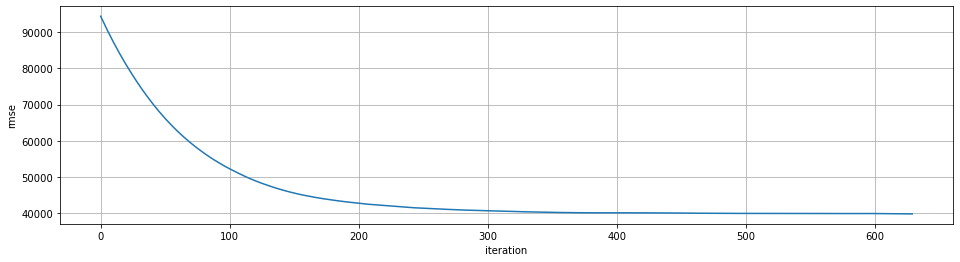

In [240]:
params = {'n_jobs': -1, 'verbose': -1, 'learning_rate': 0.01}
alb.lgb_cv(lgb_train_data, 'rmse', 1000, params, cat_cols=cat_cols)

params={'max_depth': 2, 'num_leaves': 2}  res=40365.495910  iter=1493
params={'max_depth': 2, 'num_leaves': 3}  res=39313.229690  iter=1331
params={'max_depth': 2, 'num_leaves': 4}  res=38919.416830  iter=920
params={'max_depth': 2, 'num_leaves': 5}  res=38919.416830  iter=920
params={'max_depth': 3, 'num_leaves': 2}  res=40365.495910  iter=1493
params={'max_depth': 3, 'num_leaves': 3}  res=39313.229690  iter=1331
params={'max_depth': 3, 'num_leaves': 4}  res=38995.520930  iter=959
params={'max_depth': 3, 'num_leaves': 5}  res=39375.341840  iter=1043
params={'max_depth': 4, 'num_leaves': 2}  res=40365.495910  iter=1493
params={'max_depth': 4, 'num_leaves': 3}  res=39313.229690  iter=1331
params={'max_depth': 4, 'num_leaves': 4}  res=38995.520930  iter=959
params={'max_depth': 4, 'num_leaves': 5}  res=39566.472640  iter=865
params={'max_depth': 5, 'num_leaves': 2}  res=40365.495910  iter=1493
params={'max_depth': 5, 'num_leaves': 3}  res=39313.229690  iter=1331
params={'max_depth': 5, '

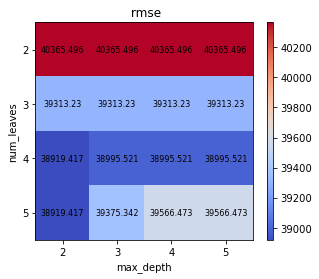

Best cv score: 38919.41683
Best params: {'max_depth': 2, 'num_leaves': 4}
Best iteration: 920


In [246]:
model_params = {'n_jobs': -1, 'verbose': -1, 'learning_rate': 0.01}
grid_params = {'num_leaves': range(2,6), 'max_depth': range(2,6)}
cvb = alb.lgb_gridCV(lgb_train_data, 'rmse', N=2000, model_params=model_params, 
                              grid_params=grid_params, cat_cols=cat_cols)

params={'lambda_l1': 0, 'lambda_l2': 0}  res=38919.416830  iter=920
params={'lambda_l1': 0, 'lambda_l2': 0.01}  res=38907.608280  iter=929
params={'lambda_l1': 0, 'lambda_l2': 0.1}  res=38904.155690  iter=916
params={'lambda_l1': 0, 'lambda_l2': 1}  res=38913.505480  iter=950
params={'lambda_l1': 0.01, 'lambda_l2': 0}  res=38919.416840  iter=920
params={'lambda_l1': 0.01, 'lambda_l2': 0.01}  res=38907.608280  iter=929
params={'lambda_l1': 0.01, 'lambda_l2': 0.1}  res=38904.155690  iter=916
params={'lambda_l1': 0.01, 'lambda_l2': 1}  res=38913.505490  iter=950
params={'lambda_l1': 0.1, 'lambda_l2': 0}  res=38919.416870  iter=920
params={'lambda_l1': 0.1, 'lambda_l2': 0.01}  res=38907.608320  iter=929
params={'lambda_l1': 0.1, 'lambda_l2': 0.1}  res=38904.155730  iter=916
params={'lambda_l1': 0.1, 'lambda_l2': 1}  res=38913.505520  iter=950
params={'lambda_l1': 1, 'lambda_l2': 0}  res=38919.418490  iter=920
params={'lambda_l1': 1, 'lambda_l2': 0.01}  res=38907.655260  iter=929
params={'l

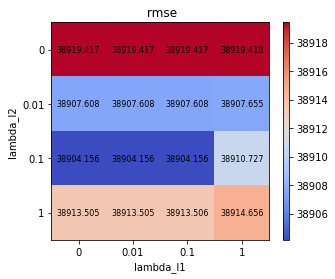

Best cv score: 38904.15569
Best params: {'lambda_l1': 0, 'lambda_l2': 0.1}
Best iteration: 916


,cv score,iter,time
"{'lambda_l1': 0, 'lambda_l2': 0}",38919.417,920,3.644
"{'lambda_l1': 0, 'lambda_l2': 0.01}",38907.608,929,3.599
"{'lambda_l1': 0, 'lambda_l2': 0.1}",38904.156,916,3.563
"{'lambda_l1': 0, 'lambda_l2': 1}",38913.505,950,3.699
"{'lambda_l1': 0.01, 'lambda_l2': 0}",38919.417,920,3.596
"{'lambda_l1': 0.01, 'lambda_l2': 0.01}",38907.608,929,3.619
"{'lambda_l1': 0.01, 'lambda_l2': 0.1}",38904.156,916,3.571
"{'lambda_l1': 0.01, 'lambda_l2': 1}",38913.505,950,3.781
"{'lambda_l1': 0.1, 'lambda_l2': 0}",38919.417,920,3.685
"{'lambda_l1': 0.1, 'lambda_l2': 0.01}",38907.608,929,4.357


In [247]:
model_params = {'n_jobs': -1, 'verbose': -1, 'learning_rate': 0.01, 'max_depth': 2, 'num_leaves': 4}
grid_params = {'lambda_l1': [0,0.01,0.1,1], 'lambda_l2': [0,0.01,0.1,1]}
alb.lgb_gridCV(lgb_train_data, 'rmse', N=2000, model_params=model_params, grid_params=grid_params, cat_cols=cat_cols)

Выбираем LightGBM. Тестируем модель

In [202]:
lgb_test_data = lgb.Dataset(X_test, label=y_test, free_raw_data=False, silent=True, categorical_feature=cat_cols)
lgb_test_data.construct()

In [248]:
model_params = {'n_jobs': -1, 'verbose': -1, 
                'learning_rate': 0.01, 'num_iterations': 1000,
                'max_depth': 2, 'num_leaves': 4,
                'lambda_l2': 0.1}
model = lgb.train(model_params, lgb_train_data, categorical_feature=cat_cols)

C:\Users\albri\.conda\envs\python38\lib\site-packages\lightgbm\engine.py:149: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


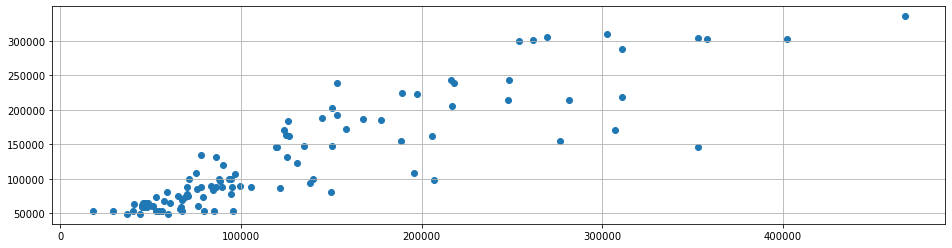

In [249]:
pred = model.predict(X_test_lgb)
plt.scatter(y_test, pred)
plt.grid()
plt.show()

In [250]:
print('rmse model =', np.round(mean_squared_error(y_test, pred, squared=False),3))

rmse model = 44669.832


In [242]:
print('rmse dummy =', np.round(mean_squared_error(y_test, X_test['season'], squared=False),3))

rmse dummy = 47167.753


Для продакшена обучаем модель на всех данных за 2019 год

In [253]:
lgb_data = lgb.Dataset(X_lgb, label=y, free_raw_data=False, silent=True)
lgb_data.construct()

In [254]:
model_params = {'n_jobs': -1, 'verbose': -1, 
                'learning_rate': 0.01, 'num_iterations': 1000,
                'max_depth': 2, 'num_leaves': 4,
                'lambda_l2': 0.1}
model = lgb.train(model_params, lgb_data)

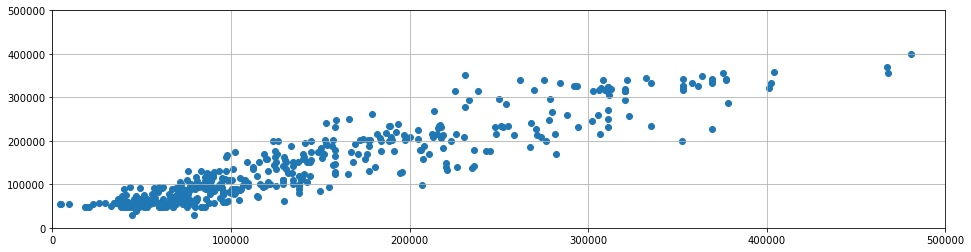

In [258]:
pred = model.predict(X_lgb)
plt.scatter(y, pred)
plt.grid()
plt.xlim(0,500000)
plt.ylim(0,500000)
plt.show()

In [228]:
model.save_model('lgb_booster.mdl')